In [3]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import time
from typing import Dict, Any, Tuple
import logging
from logging.handlers import RotatingFileHandler
import os
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import powerlaw
import random

from collections import defaultdict
import scipy.stats as stats

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Preprocessing

Key output: top_officers.csv

In [4]:
icij_data_path = Path("datasets/ICIJ/data")

addresses_path = icij_data_path / "nodes-addresses.csv"
officers_path = icij_data_path / "nodes-officers.csv"
entities_path = icij_data_path / "nodes-entities.csv"
intermediaries_path = icij_data_path / "nodes-intermediaries.csv"
others_path = icij_data_path / "nodes-others.csv"
relationships_path = icij_data_path / "relationships.csv"

officers_df = pd.read_csv(officers_path)
entities_df = pd.read_csv(entities_path)
intermediaries_df = pd.read_csv(intermediaries_path)
others_df = pd.read_csv(others_path)
relationships_df = pd.read_csv(relationships_path)
addresses_df = pd.read_csv(addresses_path)



print(f"Officers: {officers_df.shape[0]} rows")
print(f"Entities: {entities_df.shape[0]} rows")
print(f"Intermediaries: {intermediaries_df.shape[0]} rows")
print(f"Relationships: {relationships_df.shape[0]} rows")

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_77847/4152779618.py:11: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  entities_df = pd.read_csv(entities_path)
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_77847/4152779618.py:14: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  relationships_df = pd.read_csv(relationships_path)


Officers: 771315 rows
Entities: 814344 rows
Intermediaries: 26768 rows
Relationships: 3339267 rows


Goal: scraping the biggest 10% of the intermediaries and getting information on them.

Biggest 10% by lookign at relationsships_df and limiting to those relations wherei t's "intermediary_of". Intermediary is ALWAYS the start node in those cases.



Power law fit results:
Alpha: 1.984
xmin: 1.000

Log likelihood ratio tests (R) and p-values:

Power law vs exponential:
R = 54141.805
p = 0.000
Power law is significantly better fit than exponential

Power law vs lognormal:
R = 4.657
p = 0.000
Power law is significantly better fit than lognormal


/Users/oscarjuliusadserballe/Library/Caches/pypoetry/virtualenvs/bachelorthesiscode-2l6t-stA-py3.12/lib/python3.12/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


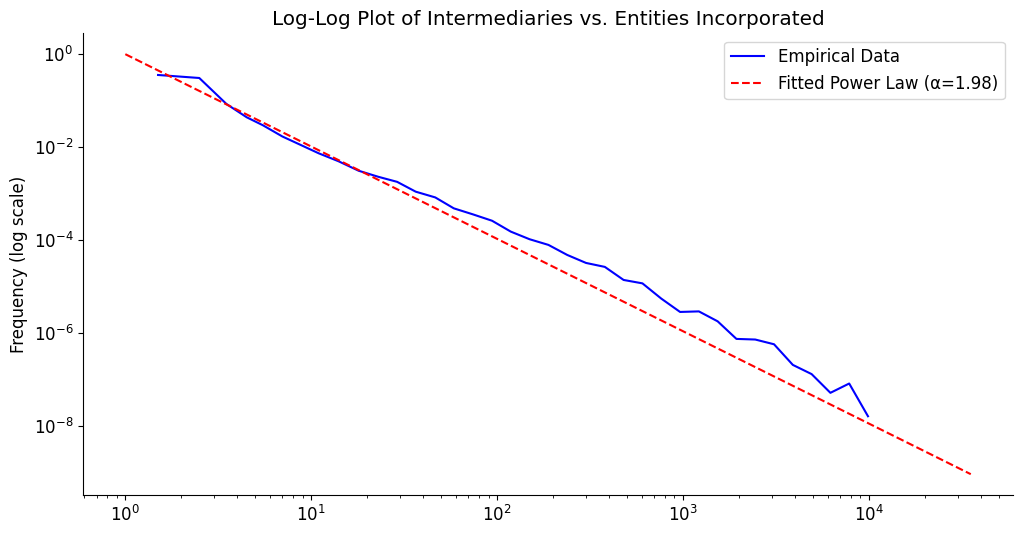

In [6]:
import powerlaw
import numpy as np

intermediary_connections = relationships_df[relationships_df['rel_type'] == 'intermediary_of']
officers_per_intermediary = intermediary_connections.groupby('node_id_start').size()

fit = powerlaw.Fit(officers_per_intermediary, xmin=1)

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()

fit.plot_pdf(color='b', label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Fitted Power Law (α={fit.alpha:.2f})')

plt.title('Log-Log Plot of Intermediaries vs. Entities Incorporated')
plt.ylabel('Frequency (log scale)')
plt.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

distributions = ['exponential', 'lognormal']
R, p = {}, {}
for dist in distributions:
    R[dist], p[dist] = fit.distribution_compare('power_law', dist)

print(f"\nPower law fit results:")
print(f"Alpha: {fit.alpha:.3f}")
print(f"xmin: {fit.xmin:.3f}")
print(f"\nLog likelihood ratio tests (R) and p-values:")
for dist in distributions:
    print(f"\nPower law vs {dist}:")
    print(f"R = {R[dist]:.3f}")
    print(f"p = {p[dist]:.3f}")
    if R[dist] > 0:
        if p[dist] < 0.05:
            print(f"Power law is significantly better fit than {dist}")
        else:
            print(f"Power law is better fit than {dist}, but not significantly")
    else:
        if p[dist] < 0.05:
            print(f"{dist} is significantly better fit than power law")
        else:
            print(f"{dist} is better fit than power law, but not significantly")

plt.show()

In [172]:
def get_top_percentage_of_intermediaries(percentage: float):
    intermediary_connections = relationships_df[relationships_df['rel_type'] == 'intermediary_of']
    officers_per_intermediary = intermediary_connections.groupby('node_id_start').size().reset_index()
    officers_per_intermediary.columns = ['node_id', 'officer_count']

    # Join with intermediary_df to get names
    intermediary_stats = officers_per_intermediary.merge(
        intermediaries_df[['node_id', 'name', 'country_codes']], 
        on='node_id', 
        how='left'
    )

    n_top = int(len(intermediary_stats) * percentage)
    top_intermediaries = intermediary_stats.nlargest(n_top, 'officer_count')

    print(f"Top {n_top} intermediaries representing {percentage*100}% of all officer relationships:\n")
    print(top_intermediaries[['name', 'country_codes', 'officer_count']]
        .sort_values('officer_count', ascending=False)
        .to_string(index=False))

    total_officers = officers_per_intermediary['officer_count'].sum()
    top_officers = top_intermediaries['officer_count'].sum()
    print(f"\nThese top {n_top} intermediaries handle {(top_officers/total_officers*100):.1f}% of all officer relationships")
    return top_intermediaries

Top 1330 intermediaries representing 5.0% of all officer relationships:

                                                               name country_codes  officer_count
                                      Morning Star Holdings Limited           KNA          35358
                            MOSSACK FONSECA & CO. (BAHAMAS) LIMITED           BHS          14901
                                        UBS TRUSTEES (BAHAMAS) LTD.           BHS           9717
                                        CREDIT SUISSE TRUST LIMITED           BHS           8299
                               TRIDENT CORPORATE SERVICES (BAH) LTD           BHS           8286
                                                   MMG BAHAMAS LTD.           BHS           8149
                                  ORION HOUSE SERVICES (HK) LIMITED           HKG           7016
                                                      Internal User           BHS           6607
                                   Unitrust Corporate 

# Agentic Component: Scrape using Tavily

Scrapes everything from `top_intermediaries.csv`

Key output: `classified_intermediaries.csv`

In [175]:
# Setup logging
os.makedirs('logs', exist_ok=True)
logger = logging.getLogger('intermediary_classifier')
logger.setLevel(logging.DEBUG)

handler = RotatingFileHandler(
    'logs/intermediary_classifier.log',
    maxBytes=1024*1024,  # 1MB
    backupCount=5
)
handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(handler)

In [180]:
import os
import json
import logging
from enum import Enum
from typing import TypedDict, List, Optional, Dict, Any
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import TavilySearchResults

MAX_ITERATIONS = 2

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if not TAVILY_API_KEY:
    logger.warning("TAVILY_API_KEY environment variable not set. Search functionality will fail.")

# --- Enums and Pydantic Models ---

class Intermediary(Enum):
    tax = "Tax Expert"
    legal = "Legal Expert"
    admin = "Administrator"
    investment = "Investment Advisor"

class Confidence(Enum):
    low = "Low"
    high = "High"

class SearchDecision(BaseModel):
    """Schema for deciding whether more information is needed"""
    needs_more_info: bool = Field(description="Whether more information is needed based on the current search log.")
    additional_query_string: str = Field(description="Specific search query string if more info is needed. Should be None if needs_more_info is False.")
    reasoning: str = Field(description="Explanation for the decision and the additional query if applicable.")

class ClassificationResult(BaseModel):
    """Schema for the classification output"""
    classification: Intermediary = Field(description="The type of intermediary")
    role_muddled: bool = Field(description="Whether the type of intermediary role is muddled")
    role_muddled_reasoning: str = Field(description="Brief justification for the role muddled")
    is_individual: bool = Field(description="Whether the intermediary is an individual")
    job_title: str = Field(description="The job title of the intermediary")
    confidence: Confidence = Field(description="Confidence either low or high. Use low if unsure or information is limited.")
    justification: str = Field(description="Detailed justification for the classification")
    key_evidence: List[str] = Field(description="Specific evidence points supporting the classification")

class IntermediaryData(BaseModel):
    """Basic data about the intermediary being analyzed."""
    name: str

# --- State Definition ---

class SearchLogEntry(TypedDict):
    """Structure for logging each search attempt."""
    iteration: int
    query: str
    results: List[Dict[str, Any]] 
    error: Optional[str] 

class State(TypedDict):
    """The workflow state."""
    intermediary_data: IntermediaryData 
    search_log: List[SearchLogEntry]   
    search_iteration: int              
    max_iterations: int                
    current_query: Optional[str]       
    needs_more_info: bool              
    classification_result: Optional[ClassificationResult] 
    error: Optional[str]               

# --- Tool and LLM Initialization ---

tavily_search = TavilySearchResults(
    max_results=5,
    api_key=TAVILY_API_KEY,
    exclude_domains=["offshoreleaks.icij.org"] 
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0,
    max_tokens=None, 
    timeout=None,
    max_retries=2,
)

llm_with_classification = llm.with_structured_output(ClassificationResult)
llm_with_search_decision = llm.with_structured_output(SearchDecision)

# --- Graph Nodes ---

def initial_search_node(state: State) -> Dict[str, Any]:
    """Performs the initial search based on the intermediary's name."""
    iteration = 0
    intermediary_name = state["intermediary_data"].name
    logger.info(f"[Iteration {iteration}] Starting initial search for: '{intermediary_name}'")

    query = intermediary_name 
    search_results = []
    search_error = None

    try:
        search_results = tavily_search.invoke(query)
        logger.info(f"[Iteration {iteration}] Initial search for '{query}' completed with {len(search_results)} results.")
    except Exception as e:
        logger.error(f"[Iteration {iteration}] Initial search failed for query '{query}': {e}", exc_info=True)
        search_error = str(e)

    log_entry: SearchLogEntry = {
        "iteration": iteration,
        "query": query,
        "results": search_results,
        "error": search_error
    }

    return {
        "search_log": [log_entry], # Initialize the log
        "search_iteration": iteration + 1, # Move to iteration 1 for potential next search
        "current_query": None, # No query set yet for the *next* step
        "needs_more_info": False # Assume not needed until analysis
    }

def additional_search_node(state: State) -> Dict[str, Any]:
    """Performs an additional search based on the query set in the state."""
    iteration = state["search_iteration"]
    query = state.get("current_query")

    if not query:
        logger.warning(f"[Iteration {iteration}] Additional search node called, but no 'current_query' found in state. Skipping search.")
        return {} 

    logger.info(f"[Iteration {iteration}] Starting additional search for: '{query}'")
    search_results = []
    search_error = None

    try:
        search_results = tavily_search.invoke(query)
        logger.info(f"[Iteration {iteration}] Additional search for '{query}' completed with {len(search_results)} results.")
    except Exception as e:
        logger.error(f"[Iteration {iteration}] Additional search failed for query '{query}': {e}", exc_info=True)
        search_error = str(e)

    log_entry: SearchLogEntry = {
        "iteration": iteration,
        "query": query,
        "results": search_results,
        "error": search_error
    }

    updated_log = state["search_log"] + [log_entry]

    return {
        "search_log": updated_log,
        "search_iteration": iteration + 1, # Increment for the *next* potential iteration
        "current_query": None, # Clear the current query after execution
        "needs_more_info": False # Reset flag, analysis node will set it again if needed
    }


def analyze_and_decide_node(state: State) -> Dict[str, Any]:
    """
    Analyzes collected information (from search_log).
    Decides if more information is needed or proceeds to classification.
    """
    iteration = state["search_iteration"] 
    intermediary_name = state["intermediary_data"].name
    search_log = state["search_log"]
    max_iterations = state["max_iterations"]

    logger.info(f"Starting analysis for '{intermediary_name}' after iteration {iteration - 1}.")
    logger.debug(f"Current search log: {json.dumps(search_log, indent=2)}")

    # --- Decision Prompt: Need More Info? ---
    log_summary_for_decision = "\n".join(
        [f"Iter {entry['iteration']} Query: '{entry['query']}' ({len(entry['results'])} results, Error: {entry['error'] or 'None'})" for entry in search_log]
    )

    search_decision_prompt = f"""
    Analyze the search log regarding the intermediary: {intermediary_name}

    Search History:
    {log_summary_for_decision}
    (Full results available if needed)

    Based *only* on the information gathered so far, do we have enough details to confidently classify the intermediary's primary role (Tax Expert, Legal Expert, Administrator, Investment Advisor)?

    Consider:
    - Is there specific evidence pointing to one role?
    - Is the information contradictory or too general?
    - Are there unanswered questions crucial for classification?

    If NO, specify 'needs_more_info: true' and provide a *single, specific* `additional_query_string` to find the missing information.
    If YES, specify 'needs_more_info: false' and set `additional_query_string` to null or omit it.

    Current search iteration count: {iteration}. Max iterations: {max_iterations}.
    You should lean towards 'needs_more_info: false' if the maximum iterations are reached.
    """
    logger.debug("Invoking LLM for search decision...")
    search_decision = llm_with_search_decision.invoke(search_decision_prompt)
    logger.debug(f"Search decision received: Needs more info: {search_decision.needs_more_info}, Query: '{search_decision.additional_query_string}', Reason: {search_decision.reasoning}")

    # --- Branching Logic ---

    if search_decision.needs_more_info and iteration < max_iterations and search_decision.additional_query_string:
        logger.info(f"Decision: More information needed. Reason: {search_decision.reasoning}")
        logger.info(f"Next query suggested: '{search_decision.additional_query_string}'")
        return {
            "needs_more_info": True,
            "current_query": search_decision.additional_query_string,
        }
    else:
        if iteration >= max_iterations:
            logger.info("Decision: Max search iterations reached. Proceeding to final classification.")
        elif not search_decision.needs_more_info:
             logger.info("Decision: Sufficient information gathered (or LLM decided so). Proceeding to final classification.")
        else: 
             logger.warning("Decision: LLM indicated more info needed but provided no query or max iterations reached. Proceeding to classification with current info.")


        # --- Classification Prompt ---
        log_summary_for_classification = json.dumps(search_log, indent=2) 

        classification_prompt = f"""
        Classify the intermediary: {intermediary_name}

        Based *only* on the information gathered in the following search log. 
        {log_summary_for_classification}

        Classify this intermediary into ONE of these categories based on their likely primary role in offshore activities:
        - Tax Expert: Focuses on tax planning, compliance, advisory. Keywords: tax advisory, international tax, tax compliance, tax returns, transfer pricing, VAT, tax structuring.
        - Legal Expert: Focuses on legal structuring, compliance, incorporation, representation. Keywords: legal services, corporate law, entity formation, incorporation, contracts, litigation, legal opinions, regulatory compliance, M&A legal, lawyer, attorney, solicitor.
        - Administrator: Focuses on accounting, auditing, financial reporting, company administration. Keywords: accounting, bookkeeping, audit, financial statements, reporting, company secretarial, payroll, administration services, domiciliation, accountant, auditor.
        - Investment Advisor: Focuses on managing financial assets and investments. Keywords: investment management, wealth management, asset management, portfolio management, financial planning, investment strategy, securities, funds, financial advisor.

        Provide a structured classification including:
        - classification (Enum: Tax Expert, Legal Expert, Administrator, Investment Advisor)
        - role_muddled (bool: true if the role seems mixed or unclear)
        - role_muddled_reasoning (str: explanation if role_muddled is true)
        - is_individual (bool: based on the name and findings, is this likely a person?)
        - job_title (str: inferred job title if possible, e.g., "Lawyer", "Accountant", "Director", or "Unknown")
        - confidence (Enum: Low, High - Use Low if evidence is sparse, contradictory, or confidence in the source/relevance is low)
        - justification (str: detailed reasoning for the classification, referencing the search log)
        - key_evidence (list[str]: specific snippets or findings from the search results supporting the classification)

        Analyze the content of the search results carefully. Prioritize information directly describing the intermediary's services or professional role.
        """
        logger.debug("Invoking LLM for final classification...")
        classification_result = llm_with_classification.invoke(classification_prompt)
        logger.info("Classification completed.")
        logger.debug(f"Classification result: {classification_result.model_dump_json(indent=2)}")

        return {
            "needs_more_info": False, # Stop searching
            "classification_result": classification_result, # Store the final result object
            "current_query": None, # No further queries needed
        }

# Workflow def'n

def create_workflow(max_iterations: int = MAX_ITERATIONS):
    """Creates the LangGraph workflow."""
    workflow = StateGraph(State)

    workflow.add_node("initial_search", initial_search_node)
    workflow.add_node("analyze_and_decide", analyze_and_decide_node)
    workflow.add_node("additional_search", additional_search_node)

    workflow.set_entry_point("initial_search")

    workflow.add_edge("initial_search", "analyze_and_decide")

    workflow.add_conditional_edges(
        "analyze_and_decide",
        lambda state: "additional_search" if state.get("needs_more_info", False) else END,
        {
            "additional_search": "additional_search",
            END: END
        }
    )

    workflow.add_edge("additional_search", "analyze_and_decide")

    logger.info(f"Workflow graph created with max_iterations = {max_iterations}.")
    return workflow.compile()

def classify_intermediary(intermediary_name: str, max_iterations: int = 3) -> Dict[str, Any]:
    """Main function to classify an intermediary starting with just its name."""
    logger.info(f"Starting classification workflow for '{intermediary_name}'...")

    if not TAVILY_API_KEY:
        logger.error("Cannot proceed without TAVILY_API_KEY.")
        return {"error": "TAVILY_API_KEY environment variable not set."}

    app = create_workflow(max_iterations=max_iterations)

    # initial state
    initial_state: State = {
        "intermediary_data": IntermediaryData(name=intermediary_name),
        "search_log": [],
        "search_iteration": 0,
        "max_iterations": max_iterations,
        "current_query": None,
        "needs_more_info": False,
        "classification_result": None,
        "error": None
    }

    final_state = None
    try:
        final_state = app.invoke(initial_state)
        logger.info(f"Classification workflow for '{intermediary_name}' completed.")

        # Return a serializable version of the final state
        if final_state:
             if final_state.get("classification_result"):
                 final_state["classification_result"] = final_state["classification_result"].model_dump()
             return final_state
        else:
            logger.error("Workflow execution returned None.")
            return {"error": "Workflow execution failed unexpectedly.", "intermediary_name": intermediary_name}

    except Exception as e:
        logger.error(f"Workflow for '{intermediary_name}' failed: {str(e)}", exc_info=True)

        # Try to return the state up to the point of failure if possible
        error_state = final_state or initial_state 
        error_state["error"] = f"Workflow failed: {str(e)}"
        if error_state.get("classification_result") and isinstance(error_state["classification_result"], BaseModel):
             error_state["classification_result"] = error_state["classification_result"].model_dump() # Serialize Pydantic model
        return error_state

2025-04-28 22:20:15,418 - INFO - Starting classification workflow for 'skiddibob'...
2025-04-28 22:20:15,425 - INFO - Workflow graph created with max_iterations = 2.
2025-04-28 22:20:15,434 - INFO - [Iteration 0] Starting initial search for: 'skiddibob'
2025-04-28 22:20:15,440 - DEBUG - Starting new HTTPS connection (1): api.tavily.com:443


Running classification for: skiddibob


2025-04-28 22:20:17,028 - DEBUG - https://api.tavily.com:443 "POST /search HTTP/1.1" 433 121
2025-04-28 22:20:17,032 - INFO - [Iteration 0] Initial search for 'skiddibob' completed with 70 results.
2025-04-28 22:20:17,036 - INFO - Starting analysis for 'skiddibob' after iteration 0.
2025-04-28 22:20:17,038 - DEBUG - Current search log: [
  {
    "iteration": 0,
    "query": "skiddibob",
    "results": "HTTPError('433 Client Error:  for url: https://api.tavily.com/search')",
    "error": null
  }
]
2025-04-28 22:20:17,040 - DEBUG - Invoking LLM for search decision...
2025-04-28 22:20:18,862 - DEBUG - Search decision received: Needs more info: True, Query: 'skiddibob role or profession', Reason: The initial search for 'skiddibob' doesn't provide enough information to determine their primary role. A more specific query like 'skiddibob role or profession' is needed to understand their expertise (Tax, Legal, Admin, Investment).
2025-04-28 22:20:18,863 - INFO - Decision: More information nee


Final State (skiddibob):
Running classification for: PricewaterhouseCoopers Advisory Services


2025-04-28 22:20:28,614 - DEBUG - https://api.tavily.com:443 "POST /search HTTP/1.1" 433 121
2025-04-28 22:20:28,617 - INFO - [Iteration 0] Initial search for 'PricewaterhouseCoopers Advisory Services' completed with 70 results.
2025-04-28 22:20:28,620 - INFO - Starting analysis for 'PricewaterhouseCoopers Advisory Services' after iteration 0.
2025-04-28 22:20:28,622 - DEBUG - Current search log: [
  {
    "iteration": 0,
    "query": "PricewaterhouseCoopers Advisory Services",
    "results": "HTTPError('433 Client Error:  for url: https://api.tavily.com/search')",
    "error": null
  }
]
2025-04-28 22:20:28,623 - DEBUG - Invoking LLM for search decision...
2025-04-28 22:20:30,816 - DEBUG - Search decision received: Needs more info: True, Query: 'PricewaterhouseCoopers Advisory Services primary role', Reason: The initial search provides general information about PricewaterhouseCoopers Advisory Services, but it doesn't specify their primary role. To classify them accurately, I need to f


Final State (PwC):


In [181]:
def get_relevant_classification_data(result: Dict[str, Any]) -> Tuple[str, float, bool, str, Dict[str, Any]]:
    """Extract relevant classification data from the result"""
    classification_result = result.get("classification_result")

    classification = classification_result.get("classification").value
    confidence = classification_result.get("confidence").value
    justification = classification_result.get("justification")

    role_muddled = classification_result.get("role_muddled")
    role_muddled_reasoning = classification_result.get("role_muddled_reasoning")

    is_individual = classification_result.get("is_individual")
    job_title = classification_result.get("job_title")
    
    # Search log
    search_log = result.get("search_log")
    search_iterations = result.get("search_iteration")

    return (
        classification, confidence, role_muddled, role_muddled_reasoning, justification,
        is_individual, job_title, search_log, search_iterations
    )

def process_intermediaries(df_path, output_path, max_iterations=3):
    """Process all intermediaries from the DataFrame with state management"""
    
    df = pd.read_csv(df_path)
    
    # load existing results
    try:
        results_df = pd.read_csv(output_path)
        processed_names = set(results_df['name'].values)
        print(f"Found {len(processed_names)} already processed intermediaries")

    except FileNotFoundError:
        results_df = pd.DataFrame(columns=[
            'name', 'classification', 'confidence', 
            'role_muddled', 'role_muddled_reasoning', 'justification', 'is_individual',
            'job_title', 'search_log', 'search_iterations'
        ])
        processed_names = set()
        print("Starting fresh classification process")
    
    # filter for unprocessed intermediaries
    to_process = df[~df['name'].isin(processed_names)]
    
    print(f"Processing {len(to_process)} intermediaries...")
    for idx, row in tqdm(to_process.iterrows(), total=len(to_process)):
        intermediary_name = row['name']
        
        try:
            result = classify_intermediary(intermediary_name, max_iterations=max_iterations)
            
            classification, confidence, role_muddled, role_muddled_reasoning, justification, is_individual, job_title, search_log, search_iterations = get_relevant_classification_data(result)
            
            new_row = pd.DataFrame([{
                'name': intermediary_name,
                'classification': classification,
                'confidence': confidence,
                'role_muddled': role_muddled,
                'role_muddled_reasoning': role_muddled_reasoning,
                'justification': justification,
                'is_individual': is_individual,
                'job_title': job_title,
                'search_log': str(search_log),
                'search_iterations': search_iterations
            }])
            
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            
            results_df.to_csv(output_path, index=False)
            
            tqdm.write(f"Classified {intermediary_name} as {classification}")
            
        except Exception as e:
            tqdm.write(f"Error processing {intermediary_name}: {str(e)}")

            error_row = pd.DataFrame([{
                'name': intermediary_name,
                'classification': 'ERROR',
                'confidence': None, 
                'role_muddled': False,
                'role_muddled_reasoning': None,
                'justification': str(e),
                'is_individual': None,
                'job_title': None,
                'search_log': None,
                'search_iterations': None
            }])
            results_df = pd.concat([results_df, error_row], ignore_index=True)
            results_df.to_csv(output_path, index=False)
        
        time.sleep(1)
    
    return results_df

print("Starting agent workflow...")

results_2 = process_intermediaries(
    df_path="enrichment_data/top_5_percent_intermediaries.csv",
    output_path="enrichment_data/enriched_top_5_percent_intermediaries.csv",
    max_iterations=2
)

('Administrator',
 'Low',
 False,
 '',
 "Based on the name 'PricewaterhouseCoopers Advisory Services', it is likely an administration service. However, due to the lack of search results, the confidence is low.",
 False,
 'Unknown',
 [{'iteration': 0,
   'query': 'PricewaterhouseCoopers Advisory Services',
   'results': "HTTPError('433 Client Error:  for url: https://api.tavily.com/search')",
   'error': None},
  {'iteration': 1,
   'query': 'PricewaterhouseCoopers Advisory Services primary role',
   'results': "HTTPError('433 Client Error:  for url: https://api.tavily.com/search')",
   'error': None}],
 2)